# Create LULC

In [30]:
%matplotlib inline
%load_ext chime

import os
from glob import glob
import pickle
import chime

import rasterio as rio
import gdal
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage.morphology import binary_closing, binary_opening, square, remove_small_holes, disk, square
#from Functions import readResampledWindow, getSentinelBandFile

from skimage.filters.rank import modal, mean_bilateral
from datetime import datetime, timedelta, time
from time import sleep
from random import randint
import psutil
import nbimporter
#from KeyFunctions import *
import chime
from utils import *
from skimage.morphology import binary_closing, binary_opening, square, remove_small_holes, disk, square, remove_small_objects

import richdem as rd

import lightgbm as lgb


def throttleProcessors(workDayStart, workDayEnd):
    startPause = time(*(map(int, workDayStart.split(':'))))
    endPause = time(*(map(int, workDayEnd.split(':'))))
    nowTime = datetime.today().time()
    if nowTime < endPause or nowTime > startPause:
        print(f"Current time is {nowTime}. Setting processor/thread use to 4")
        return 4
    else:
        return 8


def createClassifiedRaster(classification_model, ortho_file, classifiedFiles_loc, suffix=None, binaryClass=None, overwrite=False):
        try:

            start = datetime.now()
            if suffix == None:
                suffix = datetime.now().strftime("%Y%m%d")
            daynum = 1
            output_image = os.path.join(classifiedFiles_loc, os.path.basename(ortho_file))#_{day}-{daynum}.tif"))
            if binaryClass:
                #print(f"Setting binary output ({output_image})")
                #output_image = output_image.replace(".tif", f"_{binaryClass}BinaryLGBNewishGBLM.tif")
                output_image = output_image.replace(".tif", f"_{binaryClass}BinaryOptunaTunerGBLM_{suffix}.tif")
            else:
                output_image = output_image.replace(".tif", f"_MultiClassOptunaTunerGBLM_{suffix}_v2.tif")

            if os.path.exists(output_image) and not overwrite:
                #print(f"File exists ({output_image})")
                return output_image
            #else:
            #    shouldPause()

            try:
                with rio.open(ortho_file) as src:
                    kwargs = src.profile
                    data = src.read()
                    descs = list(src.descriptions)
            except:
                print(f"ERROR: Unable to open {os.path.basename(ortho_file)}. Skipping")
                return None

            if binaryClass:
                feature_names = classification_model.feature_name()
                dtype = rio.float32
            else:
                feature_names = classification_model.feature_name_
                dtype = rio.uint8

            bands = {desc:data[ib] for ib, desc in enumerate(descs)}

            #This is a training dataset not created with the others, but may be in the classifier. Create and add
            if "RGBNmean" in feature_names:
                #print("Adding RGBNmean")
                rgbnMean = np.nanmean(data[:4], axis=0).astype(data.dtype)
                bands["RGBNmean"] = rgbnMean

            if "RED_LHE" in feature_names or "GREEN_LHE" in feature_names or "BLUE_LHE" in feature_names or "NIR_LHE" in feature_names:
                path = os.path.basename(ortho_file).split("_")[0]
                row = os.path.basename(ortho_file).split("_")[1]
                print(f"PATH: {path}, ROW: {row}")
                localHisto_file = findFile(path, row, histoEqual_loc)
                with rio.open(localHisto_file) as src:
                    for i, desc in enumerate(src.descriptions):
                        bands[desc] = src.read(i+1)

            if "REDnessNorm" in feature_names or "GREENnessNorm" in feature_names or "BLUEnessNorm" in feature_names or "NIRnessNorm" in feature_names:
                bands["REDnessNorm"] = calcNessNorm(ortho_file, target_band="RED")
                bands["GREENnessNorm"] = calcNessNorm(ortho_file, target_band="GREEN")
                bands["BLUEnessNorm"] = calcNessNorm(ortho_file, target_band="BLUE")
                bands["NIRnessNorm"] = calcNessNorm(ortho_file, target_band="NIR")

            for name in feature_names:
                #if "Sentinel2_" in name:
                if name.startswith("Sentinel2_"):
                    sentBand = name.replace("Sentinel2_", "")
                    #sentBand = name.split("_")[-1]
                    #print(f"Getting sentinel {name} ({sentBand})")
                    sentFile = getSentinelBandFile(sentBand, sentinelData_dir, suffix="_2868")
                    bands[name] = readResampledWindow(sentFile, ortho_file, returnData=True)
            #return bands
            output = createClassificationFromModel(classification_model, bands, feature_names)

            #output = np.rint(output)
            # create our final mask
            #mask = (~m.mask[:,0]).reshape(*img_swp.shape[:-1])

            kwargs.update(dtype=dtype, count=1)
            with rio.open(output_image, 'w', **kwargs) as dst: 
                # write to the final file
                #dst.write(output.astype(rio.uint8), 1)
                dst.write(output.astype(dtype), 1)
                #dst.write_mask(mask)
                if not binaryClass:
                    colors = {
                        1: (12,42,235, 255),
                        2: (41, 210, 219,255),
                        3: (255, 214, 117, 255),
                        4: (171, 224, 85, 255),
                        5: (12, 100, 1, 255),
                        6: (0, 192, 32, 255),
                        7: (62, 62, 62, 255),
                        8: (160, 160, 160, 255),
                        9: (160, 37, 6, 255)
                        }
                    dst.write_colormap(1, colors)

            #print("WROTE IT")
            """if binaryClass:
                cleaned_loc = os.path.abspath(r"..\EPCExtent_30cm\Orthos_Segmentedv3_Classifiedv3_cleaned")
                cleanedOutput_loc = os.path.join(cleaned_loc, os.path.basename(ortho_file).replace(".tif","_cleaned.tif"))
                cleanedOutput = cleanIt(output, inData=bands, inClass=binaryClass, inprofile=kwargs)
                kwargs.update(nodata=0, dtype=rio.float32)
                with rio.open(cleanedOutput_loc, 'w', **kwargs) as dst:
                    #dst.write(cleanedOutput.astype(rio.uint8), 1)
                    dst.write(cleanedOutput.astype(rio.float32), 1)
            """
            end = datetime.now()
            print(f"Classified to {os.path.abspath(output_image)}. \nClassification took {end-start} -\t{end}")

            return output_image
        except:
            print(f"Failed for {output_image}")
        

def createBinaryClassifiedRaster(models, ortho_file, classifiedFiles_loc, roundConfidence=False, cleanPixels=False, overwrite=False):
    try:
        start = datetime.now()
        day = datetime.now().strftime("%Y%m%d")
        daynum = 1
        output_file = os.path.basename(ortho_file).replace(".tif", f"_BinaryOptunaTunerGBLM.tif")
        output_path = os.path.join(classifiedFiles_loc, output_file)#_{day}-{daynum}.tif"))
        cleaned_loc = os.path.abspath(r"..\EPCExtent_30cm\Orthos_Segmentedv3_Classifiedv3_cleaned")
        cleanedOutput_path = os.path.join(cleaned_loc, output_file.replace(".tif","_cleaned.tif"))

        if os.path.exists(output_path) and not overwrite:
            #print(f"File exists ({output_path})")
            return output_path
        #else:
            #shouldPause()

        try:
            with rio.open(ortho_file) as src:
                kwargs = src.profile
                kwargs.update(
                    dtype= rio.uint8,
                    count= 1,
                )
                data = src.read()
                descs = list(src.descriptions)
        except:
            print(f"ERROR: Unable to open {os.path.basename(ortho_file)}. Skipping")
            return None

        try:
            all_feature_names = set( fn for model_path in models.values() for fn in pickle.load(open(model_path, 'rb')).feature_name_ )
            #feature_names = classification_model.feature_name_
        except:
            all_feature_names = set( fn for model_path in models.values() for fn in pickle.load(open(model_path, 'rb')).feature_name() )
            #feature_names = classification_model.feature_name()

        bands = {desc:data[ib] for ib, desc in enumerate(descs)}

        #This is a training dataset not created with the others, but may be in the classifier. Create and add
        if "RGBNmean" in all_feature_names:
            #print("Adding RGBNmean")
            rgbnMean = np.nanmean(data[:4], axis=0).astype(data.dtype)
            bands["RGBNmean"] = rgbnMean

        if "RED_LHE" in all_feature_names or "GREEN_LHE" in all_feature_names or "BLUE_LHE" in all_feature_names or "NIR_LHE" in feature_names:
            path = os.path.basename(ortho_file).split("_")[0]
            row = os.path.basename(ortho_file).split("_")[1]
            print(f"PATH: {path}, ROW: {row}")
            localHisto_file = findFile(path, row, histoEqual_loc)
            with rio.open(localHisto_file) as src:
                for i, desc in enumerate(src.descriptions):
                    bands[desc] = src.read(i+1)

        if "REDnessNorm" in all_feature_names or "GREENnessNorm" in all_feature_names or "BLUEnessNorm" in all_feature_names or "NIRnessNorm" in all_feature_names:
            bands["REDnessNorm"] = calcNessNorm(ortho_file, target_band="RED")
            bands["GREENnessNorm"] = calcNessNorm(ortho_file, target_band="GREEN")
            bands["BLUEnessNorm"] = calcNessNorm(ortho_file, target_band="BLUE")
            bands["NIRnessNorm"] = calcNessNorm(ortho_file, target_band="NIR")

        for name in all_feature_names:
            #if "Sentinel2_" in name:
            if name.startswith("Sentinel2_"):
                sentBand = name.replace("Sentinel2_", "")
                #sentBand = name.split("_")[-1]
                #print(f"Getting sentinel {name} ({sentBand})")
                sentFile = getSentinelBandFile(sentBand, sentinelData_dir, suffix="_2868")
                bands[name] = readResampledWindow(sentFile, ortho_file, returnData=True)

        if roundConfidence:
            dtype = np.uint8
        else:
            dtype = np.float32
        kwargs.update(
            dtype = dtype,
            count = 9,
            nodata = 0
        )
        #output_path = f"C:/Users/BenJames/Downloads/{os.path.basename(output_path)}"
        with rio.open(output_path, 'w', **kwargs) as dst: 
            for i, class_name in enumerate(models):
                #if class_name == "Asphault" or class_name == "Pool" or class_name == "Barren" or class_name == "PondLake" or class_name == "Impervious":
                #    continue
                #print(f"on model {class_name}")
                model = pickle.load(open(models[class_name], 'rb'))
                confidenceClassification = createClassificationFromModel(model, all_bands=bands)
                #if class_name == "DenseVeg":
                #    return confidenceClassification
                # Model provides confidence values from 0 to 1, round to binary if specifid
                if roundConfidence:
                    confidenceClassification = np.rint(confidenceClassification)
                # write to the final file
                dst.write(confidenceClassification.astype(dtype), i+1)
                dst.set_band_description(i+1, class_name)

                if cleanPixels and roundConfidence:
                    cleanedOutput = cleanIt(binaryClassification==1, inData=bands, inClass=class_name)
                    with rio.open(cleanedOutput_path, "w", **kwargs) as cdst:
                        cdst.write(cleanedOutput.astype(dtype), i+1)
                        cdst.set_band_description(i+1, class_name)

        end = datetime.now()
        print(f"Classified to {os.path.abspath(output_path)}. \nClassification took {end-start} -\t{end}")
        
        
    except:
        print(f"Failed on {output_path}. Returning None")
        try:
            os.remove(output_path)
        except:
            print(f"\tUnable to remove {output_path}")
        output_path = None
            
    return output_path

def createClassificationFromModel(model, all_bands, model_features=None):
    for name, band in all_bands.items():
        numnans = len(band[np.isnan(band)])
        if numnans != 0:
            print(name, numnans)
            
    if model_features == None:
        model_features = model.feature_name()
        
    features = {fn: all_bands[fn] for fn in model_features}# if fn in descs}
    featureArrays = list(features.values())
    
    trainingFeatures = np.stack(featureArrays)
    
    #print("Input Data shape", data.shape)
    
    # read the image into the proper format, adding indices if necessary
    img_swp = np.moveaxis(trainingFeatures, 0, -1)
    img_flat = img_swp.reshape(-1, img_swp.shape[-1])
    
    #flatten bands along axis
    img_flat = img_swp.reshape(-1, img_swp.shape[-1])
    
    # remove no data values, store the indices for later use
    # a later cell makes the assumption that all bands have identical no-data value arrangements
    m = np.ma.masked_invalid(img_flat)
    #print("Mask Values", np.unique(m.mask, return_counts=True))
    to_predict = img_flat[~m.mask].reshape(-1, img_flat.shape[-1])
    #print("TO PREDICT SHAPE", to_predict.shape)
    
    # predict
    #print("Beginning prediction...", datetime.now())
    img_preds = model.predict(to_predict)
    
    #img_preds = [np.argmax(x) for x in img_preds]
    
    # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
    # resize to the original image dimensions
    output = np.zeros(img_flat.shape[0])
    output[~m.mask[:,0]] = img_preds#.flatten()
    output = output.reshape(*img_swp.shape[:-1])
    
    return output


def cleanupStructures(array, value):
    structure = array == value
    array[structure] = 0
    for i in range(3):
        structure = binary_opening(structure, square(3))
        structure = binary_closing(structure, square(5))
    
    array[structure] = value
    array = fillHolesInClass(array, value, 90)
    array = np.where(structure==1, value, array)
    
    #for i in range(5):
    #    print(f"{i} iteration"
    #non_structure_mode = modal(array, square(21), mask=array==9)
    #array = np.where(array==255, non_structure_mode, array)
    
    return array

    
def cleanIt(inarray, inData, inClass, inprofile):
    if inClass=="Pool":
        outarray = cleanupPool(inarray, inData)
    elif inClass=="Asphault":
        outarray = cleanupAsphault(inarray, inprofile)
    elif inClass=="DenseVeg":
        outarray = cleanupDenseVeg(inarray, inData)
    elif inClass=="SparseVeg":
        outarray = cleanupSparseVeg(inarray, inData)
    elif inClass=="PondLake":
        outarray = cleanupPondLake(inarray, inData)
    else:
        outarray = inarray
        
    return outarray


def fillHolesInClass(array, class_num, size_max):
    class_bool = array == class_num
    array[class_bool] = 255
    filled = remove_small_holes(class_bool, area_threshold=size_max, connectivity=1)
    array[filled] = class_num
    return array


def smoothValue(array, value, selem=square(5)):
    onlys = array == value
    for i in range(2):
        onlys = binary_closing(onlys, selem)
    array[onlys] = value
    #array[~asphault] = 255
    return array


def cleanupAsphault(a, inprofile, slope):
    # 1. Drop where any slope percentage is less than 10 degrees
    slope_thres = np.where(slope<10, 0, 1)
    slope_thres = remove_small_objects(slope_thres, min_size=1000, connectivity=1)
    a[slope_thres==1] = 0
    
    # 2. Burn in mix-used paths
    
    # 3. Remove groups of asphault pixels smaller than 1000
    a = remove_small_objects(a==1, min_size=1000, connectivity=1)
    
    # 4. Fill in holes
    a = fillHolesInClass(a, 9, 90)
    
    # 5. Open and Dilate and to smooth edges
    for i in range(5):
        a = binary_opening(a, square(3))
        a = binary_closing(a, square(5))
        
    return a 


def cleanupImpervious(a, indata):
    a[indata["MSAVI"] > 30000] = 0
    
    return a


def cleanupPool(a, indata):
    a = remove_small_objects(a==1, min_size=50, connectivity=1)
    a = remove_small_holes(a==1, area_threshold=5, connectivity=1)
    for i in range(2):
        a = binary_opening(a, disk(2))
    
    a[indata["HAG"] > 8] = 0
    a[indata["NIR"] > 10000] = 0
    a[indata["BLUEness"] < 35000] = 0
    a[indata["Slope"] > 5] = 0
    
    return a


def cleanupPondLake(a, indata):
    # drop ponds/lakes smaller than x?
    #a = removeClassSmaller(a, 1, 10000) 
    ndvi_lim = indata["NDVI"]<12000
    ndpi_lim = indata["NDPI"]>26000
    blueness_lim = indata["BLUEness"]<=40000
    a[ndvi_lim & ndpi_lim & blueness_lim] = 1
    a[a==1 & (~ndvi_lim | ~ndpi_lim | ~blueness_lim)] = 0
    a[indata["Slope"] >5 ] = 0
    a = remove_small_objects(a==1, min_size=5000, connectivity=1)
    # smooth ponds
    a = smoothValue(a, 1, selem=disk(5))
    
    return a


def cleanupIrrigated(a, value, indata=None):
     # set very green veg with high index and low brightness to irrigated
    a = remove_small_holes(a==1, area_threshold=5, connectivity=1)
    a = smoothValue(a, value, selem=disk(5))
    a[indata["MSAVI"]<=30000] = 0
    
    return a
        
def cleanupDenseVeg(a, value):
    a = smoothValue(a, value, selem=disk(2)) # smooth dense veg
    return a


def cleanupSparseVeg(a, value):
    a = smoothValue(a, value, selem=square(5)) # smooth sparse veg
    return a


def getSlopeArray(tprofile):
    with rio.open(r"R:\ProjectData\PAG2019\2ftDEMs_PAG\EPC_DEM_2015.vrt") as src:
        intrans = tprofile["transform"]
        inheight = tprofile["height"]
        inwidth = tprofile["width"]
        inres = intrans.a
        win = from_bounds(intrans.c, intrans.f-(inheight*inres), intrans.c+(inwidth*inres), intrans.f, src.transform).round_offsets().round_lengths()
        
        if win.col_off < src.width and win.row_off < src.height:
            dem = src.read(1, window=win, out_shape=(tprofile["height"], tprofile["width"]))
            slope = rd.TerrainAttribute(rd.rdarray(dem, no_data=src.nodata), attrib="slope_degrees")
            # if the read window includes an area with no-data, that means that it's outside of the region for the 2015 2ft DEM. Fill in with NED data
            if src.nodata in dem:
                slope10m = get10mNEDSlope(intrans,inheight,inwidth)
                slope = np.where(dem==src.nodata, slope10m, slope)
        else:
            # the entire window is outside of the extent of the 2ft DEM coverage; use NED
            slope = get10mNEDSlope(intrans,inheight,inwidth)
            
    return slope


def get10mNEDSlope(intrans, inheight, inwidth):
    inres = intrans.a
    with rio.open(rasterDataDir + r"/10mDEMs/DEM10mNED_slope.tif") as src10m:
        win = from_bounds(intrans.c, intrans.f-(inheight*inres), intrans.c+(inwidth*inres), intrans.f, src10m.transform).round_offsets().round_lengths()
        slope = src10m.read(1, window=win, out_shape=(inheight, inwidth))
        
    return slope


def burnShadows(a, indata, rednessNorm):
    # burn in shadows where low values, but not pool or pond
    rgbnMean = np.nanmean([indata["RED"], indata["GREEN"], indata["BLUE"], indata["NIR"]], axis=0)
    
    #a[(rgbnMean<10282) & (a!=1) & (a!=2)] = 10
    
    # if classed as pool, NIR is below 5k and rednessNorm > 0.15
    a[(a==1) & (indata["NIR"]<=5000) & (rednessNorm > 0.15)] = 10
    
    return a


def getBandByDescription(file, bandDesc):
    if type(bandDesc) == list:
        getBands = bandDesc[:]
    elif type(bandDesc) == str:
        getBands = [bandDesc]
        
    bandDict = {}
    with rio.open(file) as src:
        for band in getBands:
            try:
                index = src.descriptions.index(band)
            except:
                raise ValueError(f"Unable to find band {band} in {file}")    
            # have to increment index since tiff indicies start at 1 and not 0
            bandDict[band] = src.read(index+1)
            
    if type(bandDesc) != list:
        return bandDict[bandDesc]
    
    return bandDict


def calcNessNorm(file, target_band):
    bands = getBandByDescription(file, bandDesc=["RED", "GREEN", "BLUE", "NIR"])
    #return bands
    tband = bands[target_band]
    obands = np.stack([array for name, array in bands.items() if name != target_band])
    nessNorm = (tband-np.nanmean(obands,axis=0))/(tband+np.nanmean(obands,axis=0))
    mask = np.all(np.stack(bands.values())==0, axis=0)
    nessNorm[mask]=0
    
    return nessNorm


def calcRGDiff(file):
    bands = getBandByDescription(file, bandDesc=["RED", "GREEN"])
    rgDiff = bands["RED"]-bands["GREEN"]
    
    return rgDiff


def splitToBinary(array, limit):
    data = np.where(array>limit, 1, 0)
    
    return data

"""
def getCleanedBinary(file, orthoFile, outdir, lcClass, probLimit=0.01, overwrite=False, writeOut=False):
    ofile = os.path.join(outdir, os.path.basename(file).replace(".tif", "_clean.tif"))
    #if os.path.exists(ofile) and not overwrite and not returnData:
    #    return ofile
    if os.path.exists(ofile) and not overwrite:
        data_clean = rio.open(ofile).read(1)
    else:
        with rio.open(file) as src:
            data = src.read(1)
            kwargs = src.profile
         
        data = splitToBinary(data, probLimit)
    
        if lcClass == "Asphault":
            data_clean = cleanupAsphault(data, kwargs)
        elif lcClass == "Pool":
            #rint("Cleaning Pool")
            trainingData = getBandByDescription(orthoFile, ["HAG","NIR","BLUEness"])
            data_clean = cleanupPool(data, trainingData)
            #print("Cleaned Pool")
        elif lcClass == "PondLake":
            trainingData = getBandByDescription(orthoFile, ["NDVI","NDPI","BLUEness"])
            data_clean = cleanupPondLake(data, trainingData)
        elif lcClass == "Irrigated":
            trainingData = getBandByDescription(orthoFile, ["MSAVI"])
            data_clean = cleanupIrrigated(data, trainingData)
        else:
            raise ValueError(f"Unknown class type {lcClass}")
    
        if writeOut:
            kwargs.update(dtype=np.uint8, nodata=0)
            with rio.open(ofile, "w", nbits=1, **kwargs) as dst:
                dst.write(data_clean.astype(np.uint8), 1)
            return ofile
    
    return data_clean.astype(np.uint8)
"""
                      
def buildCleanLULC(rowIndex, r, outdir, overwrite=False):
    try:
        #shouldPause()
        
        start = datetime.now()
        ofile = f"{r.path}_{r.row}_TrainingStackV3_BinaryStack_cleaned.tif"
        output_lulc = os.path.join(outdir, ofile)
        if os.path.exists(output_lulc) and not overwrite:
            return output_lulc
        
        with rio.open(r.OrthoFile) as src:
            kwargs = src.profile
            
        #asphault = getCleanedBinary(r.AsphaultFile, r.OrthoFile, cleanBinaryDir, "Asphault", writeOut=False)
        #pool = getCleanedBinary(r.PoolFile, r.OrthoFile, cleanBinaryDir, "Pool", writeOut=False)
        #pondLake = getCleanedBinary(r.PondLakeFile, r.OrthoFile, cleanBinaryDir, "PondLake", probLimit=0.5, writeOut=False)
        
        binaryFile = r.BinaryStackFile
        
        binaryClassifications = getBandByDescription(binaryFile, list(values_2019_lookup.keys()))
        
        pondLake = splitToBinary(binaryClassifications["PondLake"], limit=0.5)
        pool = splitToBinary(binaryClassifications["Pool"], limit=0.1)
        sparseVeg = splitToBinary(binaryClassifications["SparseVeg"], limit=0.5)
        denseVeg = splitToBinary(binaryClassifications["DenseVeg"], limit=0.5)
        irrigatedLand = splitToBinary(binaryClassifications["IrrigatedLand"], limit=0.5)
        asphault = splitToBinary(binaryClassifications["Asphault"], limit=0.1)
        structures = splitToBinary(binaryClassifications["Structure"], limit=0.5)
        
        impervious = binaryClassifications["Impervious"]
        barren = binaryClassifications["Barren"]
        
        inputData = getBandByDescription(r.OrthoFile, ["RED", "GREEN", "BLUE", "NIR", "MSAVI", "HAG", "BLUEness", "NDVI", "NDPI"])
        inputData["Slope"] = getSlopeArray(kwargs)
        
        asphault = cleanupAsphault(asphault, kwargs, inputData["Slope"])
        pool = cleanupPool(pool, inputData)
        pondLake = cleanupPondLake(pondLake, inputData)
        irrigatedLand = cleanupIrrigated(irrigatedLand, 1, inputData)
        structures = cleanupStructures(structures, 1)
        sparseVeg = cleanupSparseVeg(sparseVeg, 1)
        denseVeg = cleanupDenseVeg(denseVeg, 1)
        impervious = cleanupImpervious(impervious, inputData)
        
        lulc_array = np.zeros(asphault.shape, dtype=np.uint8)
        
        lulc_array[structures == 1] = values_2019_lookup["Structure"]
        lulc_array[pool == 1] = values_2019_lookup["Pool"]
        lulc_array[pondLake == 1] = values_2019_lookup["PondLake"]
        lulc_array[irrigatedLand == 1] = values_2019_lookup["IrrigatedLand"]
        lulc_array[sparseVeg == 1] = values_2019_lookup["SparseVeg"]
        lulc_array[asphault == 1] = values_2019_lookup["Asphault"]
        lulc_array[denseVeg == 1] = values_2019_lookup["DenseVeg"]
        
        #with rio.open(r.ImperviousFile) as src:
        #    impervious = src.read(1)
        #with rio.open(r.BarrenFile) as src:
        #barren = src.read(1)
            
        # stack barren and impervious and pick class with best confidence (highest/argmax)
        barrenImp = np.stack([impervious, barren])
        bestIndex = np.argmax(barrenImp, axis=0)
        lulc_array[(lulc_array==0) & (bestIndex==0)] = values_2019_lookup["Impervious"]
        lulc_array[(lulc_array==0) & (bestIndex==1)] = values_2019_lookup["Barren"]
        
        # cleanup Barren and Impervious
        redNessNorm = calcNessNorm(r.OrthoFile, target_band="RED")
        blueNessNorm = calcNessNorm(r.OrthoFile, target_band="BLUE")
        rbNessDiff = redNessNorm - blueNessNorm
        rgDiff = calcRGDiff(r.OrthoFile)
        #  These cutoffs are kinda arbitrary based on limited sampling
        lulc_array[(lulc_array==values_2019_lookup["Impervious"]) & (rbNessDiff>=0.1) & (rgDiff>=2500)] = values_2019_lookup["Barren"]
        lulc_array[(lulc_array==values_2019_lookup["Impervious"]) & (rbNessDiff>=0.06) & (rgDiff<2500)] = values_2019_lookup["Barren"]
        lulc_array[(lulc_array==values_2019_lookup["Barren"]) & (rbNessDiff<=0.1) & (rgDiff<2500)] = values_2019_lookup["Impervious"]
        
        # burn in shadows where low values, but not pool or pond
        lulc_array = burnShadows(lulc_array, inputData, redNessNorm)
        
        
        
        kwargs.update(count=1, dtype=np.uint8, nodata=0)
        with rio.open(output_lulc, 'w', **kwargs) as dst: 
            # write to the final file
            dst.write(lulc_array, 1)
            colors = {
                1: (12,42,235, 255),
                2: (41, 210, 219,255),
                3: (255, 214, 117, 255),
                4: (171, 224, 85, 255),
                5: (12, 100, 1, 255),
                6: (0, 192, 32, 255),
                7: (62, 62, 62, 255),
                8: (160, 160, 160, 255),
                9: (160, 37, 6, 255),
                10: (0, 0, 0, 255)
                }
            dst.write_colormap(1, colors)
        print(f"Finished with #{rowIndex} - {output_lulc}")
        return output_lulc
    
    except ValueError as e:
        print(f"Failed for {r.OrthoFile}\n{e}")
        
def shouldPause(pauseTime_sec=60, memLimit_perc=50, cpuLimit_perc=80, workStart_hr=9, workEnd_hr=17):
    wait = True
    while wait:
        now_hr=datetime.now().hour
        memUsage = psutil.virtual_memory()[2]
        cpuUsage = psutil.cpu_percent(interval=0.1)
        if (memUsage > memLimit_perc or cpuUsage > cpuLimit_perc) and (now_hr >= workStart_hr or now_hr <=workEnd_hr):
            print(f"sleeping ~{pauseTime_sec}")
            sleeptime = randint(pauseTime_sec-5, pauseTime_sec+5)
            sleep(sleeptime)
        else:
            wait=False
            
            
def getnjobs():
    now = datetime.now()
    if now.hour >= 9 and now.hour < 17:
        njobs = 1
    else:
        njobs = 2
    return njobs

The chime extension is already loaded. To reload it, use:
  %reload_ext chime


In [31]:
rasterDataDir = os.path.abspath("R:/ProjectData/PAG2019")
classifiedFiles_loc = os.path.join(rasterDataDir, "EPCExtent_30cm/Orthos_Segmented_Classifiedv3")
binaryClassifiedFiles_loc = os.path.join(rasterDataDir, "EPCExtent_30cm/Orthos_Segmented_Classifiedv3_Binary")
histoEqual_loc = os.path.join(rasterDataDir, "EPCExtent_30cm/Orthos_LocalHistogramEqualized")
cleanBinaryDir = os.path.join(rasterDataDir, r"EPCExtent_30cm/Orthos_Segmented_Classifiedv3_Binary_cleaned")
v3TrainingStack_dir = os.path.join(rasterDataDir, r"EPCExtent_30cm\Orthos_Segmentedv3")
sentinelData_dir = os.path.join(rasterDataDir, r"Sentinel2Data")

ortho30cmvrt_loc = os.path.join(rasterDataDir, "EPCExtent_30cm/Orthos/EPC_30cmOrtho_2019.vrt")
hagvrt_loc = os.path.join(rasterDataDir, "EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_2015.vrt")

orthosDir = os.path.join(rasterDataDir, r"EPCExtent_30cm/Orthos_Segmentedv3")
os.makedirs(classifiedFiles_loc, exist_ok=True)
os.makedirs(binaryClassifiedFiles_loc, exist_ok=True)
os.makedirs(cleanBinaryDir, exist_ok=True)

values_2019_lookup = {'PondLake': 1, 'Pool': 2, 'Barren': 3, 'SparseVeg': 4, 'DenseVeg': 5,
                      'IrrigatedLand': 6, 'Asphault': 7, 'Impervious': 8, 'Structure': 9}

tindex = gpd.read_file("../vectors/Ortho_5kSubIndex.gpkg")
#to_process = gpd.read_file("../temp/ToProcess.gpkg")

print(f"{len(tindex)} total tile indicies")
tindex["OrthoFile"] = tindex.apply(lambda r: findFile(path=r.path, row=r.row, directory=orthosDir), axis=1)
#tindex["PropsFile"] = tindex.apply(lambda r: findFile(path=r.path, row=r.row, files=propsDir), axis=1)

# ignore tiles which don't have input variables created
#tindex = tindex[(~pd.isnull(tindex.OrthoFile))]
#print(f"{len(tindex)} tile indicies with training data already built")


#prioritize central tucson and work out from there
tindex["centroid"] = tindex.geometry.centroid
central_tile = tindex[(tindex.path == "W1004789") & (tindex.row == "N449850")]
central_point = central_tile.centroid.values[0]
tindex["DistToCenter"] = tindex.centroid.apply(lambda c: int(c.distance(central_point)))
tindex.sort_values(by="DistToCenter", inplace=True)

classifiers = {mp.split("_")[0].split("Binary")[-1]:mp for mp in glob("../Models/*20220103.sav")}

#tt = tindex[((tindex.path == "W989789") & (tindex.row == "W439850")) |
#            ((tindex.path == "W1004789") & (tindex.row == "W449850")) |
#            ((tindex.path == "W1004789") & (tindex.row == "W344850")) |
#            ((tindex.path == "W979789") & (tindex.row == "W419850")) |
#            ((tindex.path == "W1004789") & (tindex.row == "W444850")) |
#            ((tindex.path == "W919789") & (tindex.row == "W404850")) 
#           ]

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:294: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for f in features_lst:


4846 total tile indicies


64.63011363636363

3245 tiles within 32 miles
254 tiles with LULC files to be created
250 tiles (98.43%) that need training data created


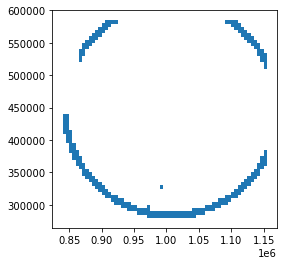

In [53]:
targetDistance_miles = 32
#cleanedLULC_dir = os.path.join(rasterDataDir, r"EPCExtent_30cm\LULC")

tindex_target = tindex[tindex.DistToCenter <= targetDistance_miles*5280].copy()
print(f"{len(tindex_target)} tiles within {targetDistance_miles} miles")
tindex_target["CleanedLULCFile"] = tindex_target.apply(lambda r: cleanBinaryDir+f"/{r.path}_{r.row}_TrainingStackV3_BinaryStack_cleaned.tif", axis=1)
tindex_target["CleanedLULCFile"] = tindex_target["CleanedLULCFile"].apply(lambda f: f if os.path.exists(f) else None)
tindex_toDo = tindex_target[tindex_target["CleanedLULCFile"].isnull()].copy()
tindex_toDo["OrthoFile"] = tindex_toDo.apply(lambda r: glob(f"{orthosDir}/{r.path}_{r.row}_*.tif"), axis=1)
tindex_toDo["OrthoFile"] = tindex_toDo["OrthoFile"].apply(lambda f: f[0] if len(f) == 1 else None)
print(f"{len(tindex_toDo)} tiles with LULC files to be created")
trainingToCreate = tindex_toDo[tindex_toDo.OrthoFile.isnull()]
print(f"{len(trainingToCreate)} tiles ({round(100*len(tindex_toDo[tindex_toDo.OrthoFile.isnull()])/len(tindex_toDo),2)}%) that need training data created")
tindex_toDo.plot()

In [54]:
%%time
print(f"Starting orthos at {datetime.now()}")
toDo_OrthoFiles = Parallel(n_jobs=5, verbose=5, backend="loky")(delayed(segmentWindowV3)(boxrow,
                                                                                         v3TrainingStack_dir,
                                                                                         ortho30cmvrt_loc,
                                                                                         hagvrt_loc,
                                                                                         returnArray=False,
                                                                                         writeOutStack=True,
                                                                                         overwrite=False)
                                                                for i, boxrow in tindex_toDo.iterrows())
print(f"Finished orthos at {datetime.now()}")
toDo_LHEFiles = Parallel(n_jobs=8, verbose=5, backend="loky")(delayed(createLocalHistogramOrtho)(boxrow,
                                                                                                 histoEqual_loc,
                                                                                                 ortho30cmvrt_loc,
                                                                                                 overwrite=False)
                                                              for i, boxrow in tindex_toDo.iterrows())

tindex_toDo["OrthoFile"] = tindex_toDo.apply(lambda r: glob(f"{orthosDir}/{r.path}_{r.row}_*.tif"), axis=1)
tindex_toDo["OrthoFile"] = tindex_toDo["OrthoFile"].apply(lambda f: f[0] if len(f) == 1 else None)
print("FINISHED")

Starting orthos at 2022-01-25 10:04:08.184092


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed: 16.8min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed: 109.2min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 259.3min
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\joblib\externals\loky\process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=5)]: Done 254 out of 254 | elapsed: 430.3min finished


Finished orthos at 2022-01-25 17:14:28.421683


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 89.2min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 226.9min
[Parallel(n_jobs=8)]: Done 254 out of 254 | elapsed: 368.1min finished


FINISHED
Wall time: 13h 18min 26s


## Binary Group Parallelized

In [ ]:
%%time
#tday = datetime.now().strftime("%Y%m%d")
tday = "20220103"

"""
asphaultFiles = Parallel(n_jobs=getnjobs())(delayed(createClassifiedRaster)(pickle.load(open(classifiers["Asphault"], "rb")),
                                                                   ortho_file= row.OrthoFile,
                                                                   classifiedFiles_loc= binaryClassifiedFiles_loc,
                                                                   binaryClass= "Asphault",
                                                                   suffix = tday,
                                                                   overwrite= False) for i, row in tindex_toDo.iterrows())

poolFiles = Parallel(n_jobs=getnjobs())(delayed(createClassifiedRaster)(pickle.load(open(classifiers["Pool"], "rb")),
                                                               ortho_file= row.OrthoFile,
                                                               classifiedFiles_loc= binaryClassifiedFiles_loc,
                                                               binaryClass= "Pool",
                                                               suffix = tday,
                                                               overwrite= False) for i, row in tindex_toDo.iterrows())

imperviousFiles = Parallel(n_jobs=getnjobs())(delayed(createClassifiedRaster)(pickle.load(open(classifiers["Impervious"], "rb")),
                                                                     ortho_file= row.OrthoFile,
                                                                     classifiedFiles_loc= binaryClassifiedFiles_loc,
                                                                     binaryClass= "Impervious",
                                                                     suffix= tday,
                                                                     overwrite= False) for i, row in tindex_toDo.iterrows())

barrenFiles = Parallel(n_jobs=getnjobs())(delayed(createClassifiedRaster)(pickle.load(open(classifiers["Barren"], "rb")),
                                                                          ortho_file= row.OrthoFile,
                                                                          classifiedFiles_loc= binaryClassifiedFiles_loc,
                                                                          binaryClass= "Barren",
                                                                          suffix = tday,
                                                                          overwrite= False) for i, row in tindex_toDo.iterrows())

pondLakeFiles = Parallel(n_jobs=getnjobs())(delayed(createClassifiedRaster)(pickle.load(open(classifiers["PondLake"], "rb")),
                                                                            ortho_file= row.OrthoFile,
                                                                            classifiedFiles_loc= binaryClassifiedFiles_loc,
                                                                            binaryClass= "PondLake",
                                                                            suffix = tday,
                                                                            overwrite= False) for i, row in tindex_toDo.iterrows())
"""
files = Parallel(n_jobs=1)(delayed(createBinaryClassifiedRaster)(models=classifiers,
                                                                 ortho_file=row.OrthoFile,
                                                                 classifiedFiles_loc=classifiedFiles_loc,
                                                                 overwrite=False,
                                                                 roundConfidence=False) for i, row in tindex_toDo.iterrows())

PATH: W989789, ROW: N329850


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\joblib\parallel.py:255: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return [func(*args, **kwargs)


Failed on R:\ProjectData\PAG2019\EPCExtent_30cm/Orthos_Segmented_Classifiedv3\W989789_N329850_TrainingStackV3_BinaryOptunaTunerGBLM.tif. Returning None
PATH: W969789, ROW: N299850
Failed on R:\ProjectData\PAG2019\EPCExtent_30cm/Orthos_Segmented_Classifiedv3\W969789_N299850_TrainingStackV3_BinaryOptunaTunerGBLM.tif. Returning None
PATH: W1079789, ROW: N309850
Classified to R:\ProjectData\PAG2019\EPCExtent_30cm\Orthos_Segmented_Classifiedv3\W1079789_N309850_TrainingStackV3_BinaryOptunaTunerGBLM.tif. 
Classification took 0:04:21.304167 -	2022-01-26 09:54:30.390595
PATH: W1144789, ROW: N524850
Classified to R:\ProjectData\PAG2019\EPCExtent_30cm\Orthos_Segmented_Classifiedv3\W1144789_N524850_TrainingStackV3_BinaryOptunaTunerGBLM.tif. 
Classification took 0:04:36.215109 -	2022-01-26 09:59:06.922694
PATH: W929789, ROW: N309850
Classified to R:\ProjectData\PAG2019\EPCExtent_30cm\Orthos_Segmented_Classifiedv3\W929789_N309850_TrainingStackV3_BinaryOptunaTunerGBLM.tif. 
Classification took 0:04:2

C:\Users\BenJames\AppData\Local\Temp/ipykernel_14896/3591094708.py:515: RuntimeWarning: invalid value encountered in true_divide
  nessNorm = (tband-np.nanmean(obands,axis=0))/(tband+np.nanmean(obands,axis=0))


Classified to R:\ProjectData\PAG2019\EPCExtent_30cm\Orthos_Segmented_Classifiedv3\W864789_N524850_TrainingStackV3_BinaryOptunaTunerGBLM.tif. 
Classification took 0:04:23.685577 -	2022-01-26 10:07:52.593146
PATH: W1144789, ROW: N374850
Classified to R:\ProjectData\PAG2019\EPCExtent_30cm\Orthos_Segmented_Classifiedv3\W1144789_N374850_TrainingStackV3_BinaryOptunaTunerGBLM.tif. 
Classification took 0:04:48.230324 -	2022-01-26 10:12:41.090488
PATH: W864789, ROW: N374850
Classified to R:\ProjectData\PAG2019\EPCExtent_30cm\Orthos_Segmented_Classifiedv3\W864789_N374850_TrainingStackV3_BinaryOptunaTunerGBLM.tif. 
Classification took 0:04:46.602604 -	2022-01-26 10:17:27.952093
PATH: W1039789, ROW: N294850
Classified to R:\ProjectData\PAG2019\EPCExtent_30cm\Orthos_Segmented_Classifiedv3\W1039789_N294850_TrainingStackV3_BinaryOptunaTunerGBLM.tif. 
Classification took 0:04:32.096802 -	2022-01-26 10:22:00.278895
PATH: W1149789, ROW: N384850
Classified to R:\ProjectData\PAG2019\EPCExtent_30cm\Orthos_

In [ ]:
tindex_toDo["BinaryStackFile"] = tindex_toDo.apply(lambda r: glob(classifiedFiles_loc + f"/{r.path}_{r.row}_TrainingStackV3_BinaryOptunaTunerGBLM.tif"), axis=1)
#tindex_toDo["AsphaultFile"] = tindex_toDo.apply(lambda r: glob(binaryClassifiedFiles_loc + f"/{r.path}_{r.row}_TrainingStackV3_AsphaultBinaryOptunaTunerGBLM_*.tif"), axis=1)
#tindex_toDo["PoolFile"] = tindex_toDo.apply(lambda r: glob(binaryClassifiedFiles_loc + f"/{r.path}_{r.row}_TrainingStackV3_PoolBinaryOptunaTunerGBLM_*.tif"), axis=1)
#tindex_toDo["PondLakeFile"] = tindex_toDo.apply(lambda r: glob(binaryClassifiedFiles_loc + f"/{r.path}_{r.row}_TrainingStackV3_PondLakeBinaryOptunaTunerGBLM_*.tif"), axis=1)
#tindex_toDo["ImperviousFile"] = tindex_toDo.apply(lambda r: glob(binaryClassifiedFiles_loc + f"/{r.path}_{r.row}_TrainingStackV3_ImperviousBinaryOptunaTunerGBLM_*.tif"), axis=1)
#tindex_toDo["BarrenFile"] = tindex_toDo.apply(lambda r: glob(binaryClassifiedFiles_loc + f"/{r.path}_{r.row}_TrainingStackV3_BarrenBinaryOptunaTunerGBLM_*.tif"), axis=1)

tindex_toDo["BinaryStackFile"] = tindex_toDo["BinaryStackFile"].apply(lambda f: f[0] if len(f) == 1 else None)
#tindex_toDo["AsphaultFile"] = tindex_toDo["AsphaultFile"].apply(lambda f: f[0] if len(f) == 1 else None)
#tindex_toDo["PoolFile"] = tindex_toDo["PoolFile"].apply(lambda f: f[0] if len(f) == 1 else None)
#tindex_toDo["PondLakeFile"] = tindex_toDo["PondLakeFile"].apply(lambda f: f[0] if len(f) == 1 else None)
#tindex_toDo["ImperviousFile"] = tindex_toDo["ImperviousFile"].apply(lambda f: f[0] if len(f) == 1 else None)
#tindex_toDo["BarrenFile"] = tindex_toDo["BarrenFile"].apply(lambda f: f[0] if len(f) == 1 else None)
tindex_toDo = tindex_toDo[tindex_toDo.BinaryStackFile.notnull()].reset_index() #  tindex_target.dropna().reset_index()
print(tindex_toDo.shape)
%chime

In [ ]:
%%time
cleanedLULC_dir = os.path.join(rasterDataDir, r"EPCExtent_30cm\LULC")
os.makedirs(cleanedLULC_dir, exist_ok=True)

tindex_toDo["CleanedLULCFile"] = tindex_toDo.apply(lambda r: cleanedLULC_dir + f"/{r.path}_{r.row}_LULC2019.tif", axis=1)
tindex_toDo["CleanedLULCFile"] = tindex_toDo["CleanedLULCFile"].apply(lambda f: f if os.path.exists(f) else None)
lulc_toDo = tindex_toDo[tindex_toDo["CleanedLULCFile"].isnull()].copy()
print(f"{len(lulc_toDo)} LULCs to be build")

cleanLULCFiles = Parallel(n_jobs=5)(delayed(buildCleanLULC)(i, row, cleanBinaryDir, overwrite=False) for i, row in lulc_toDo.iterrows())

tindex_toDo["CleanedLULCFile"] = tindex_toDo.apply(lambda r: cleanBinaryDir + f"\\{r.path}_{r.row}_TrainingStackV3_BinaryStack_cleaned.tif", axis=1)
tindex_toDo["CleanedLULCFile"] = tindex_toDo["CleanedLULCFile"].apply(lambda f: f if os.path.exists(f) else None)
tindex_toDo_comp = tindex_toDo[tindex_toDo["CleanedLULCFile"].notnull()].copy()
print(tindex_toDo_comp.shape)

%chime

In [ ]:
from rasterio.mask import mask

railroads = gpd.read_file("../vectors/PC_Railroad/railroad.shp").unary_union
railroads = railroads.buffer(20)
washes = gpd.read_file("../vectors/PC_MajorWashes/mash_maj.shp").unary_union
bridges = gpd.read_file("../vectors/BurnIns.gpkg", layer="Bridges_paved").unary_union
barren = gpd.read_file("../vectors/BurnIns.gpkg", layer="Barren").unary_union


def getGeometryMask(geometry, raster):
    if geometry.type == "Polygon":
        geometry = [geometry]
    tds, tds_trans = mask(raster, geometry, all_touched=False, crop=False, filled=False)
    
    return ~tds.mask

def burnInValuesOverLULC(rowIndex, row):
    
    lulc_file = row.CleanedLULCFile
    ortho_file = row.OrthoFile
    
    hag = getBandByDescription(ortho_file, "HAG")
    with rio.open(lulc_file) as src:
        lulc = src.read(1)
        kwargs = src.profile
        bnds = src.bounds
        railroad_mask = getGeometryMask(railroads, src)[0]
        washes_mask = getGeometryMask(washes, src)[0]
        bridges_mask = getGeometryMask(bridges, src)[0]
        mines_mask = getGeometryMask(minesLand, src)[0]
    print(lulc.shape)
    print(mines_mask.shape)
    
    
    # burn in railroads where not structure or road
    lulc[(railroad_mask) & 
         (lulc != values_2019_lookup["Structure"]) &
         (lulc != values_2019_lookup["Asphault"])] = values_2019_lookup["Barren"]
    
    #burn in bridges as asphault
    lulc[(bridges_mask)] = values_2019_lookup["Asphault"]
    #burn in Major Wash polygons as barren where major wash, 6ft above ground and classified as impervious or structure
    lulc[(washes_mask) 
         & (hag < 10) 
         & ((lulc == values_2019_lookup["Impervious"]) | (lulc == values_2019_lookup["Structure"]))] = values_2019_lookup["Barren"]
    
    lulc[(lulc!=0)
             & (mines_mask==1)
             & (lulc != values_2019_lookup["PondLake"])
             & (lulc != values_2019_lookup["Pool"])
             & (lulc != values_2019_lookup["SparseVeg"])
             & (lulc != values_2019_lookup["DenseVeg"])] = values_2019_lookup["Barren"]
    
    
    with rio.open(lulc_file, "r+") as dst:
        dst.write(lulc, 1)
        
    print(f"Finished burn in for #{rowIndex} - {row.path}, {row.row}")
    
    return lulc_file


relevantTiles = tindex_target[(tindex_target.intersects(railroads))
                   | (tindex_target.intersects(washes))
                   | (tindex_target.intersects(bridges))
                   | (tindex_target.intersects(barren))].reset_index(drop=True)

cleanedRelevantTiles = Parallel(n_jobs=10)(delayed(burnInValuesOverLULC)(i, row) for i, row in relevantTiles.iterrows())

%chime

In [ ]:
from datetime import datetime
import chime

tindex_target = tindex.dropna().reset_index()

lulcVRT_loc = "../EPCExtent_30cm/Cleaned2019LULC.vrt"
outTiff_loc = "../EPCExtent_30cm/EPC_LULC_2019.tif"
lulcVRT = gdal.BuildVRT(lulcVRT_loc, tt.CleanedLULCFile.values.tolist())
del lulcVRT

start = datetime.now()
lulcVRT_loc = "../EPCExtent_30cm/Cleaned2019LULC.vrt"
outTiff_loc = "../EPCExtent_30cm/EPC_LULC_2019.tif"
translateOptions = gdal.TranslateOptions(creationOptions=["NUM_THREADS=ALL_CPUS",
                                                          "TILED=YES",
                                                          "COMPRESS=LZW"])
lulc2019Tiff = gdal.Translate(outTiff_loc, lulcVRT_loc, options=translateOptions)
del lulc2019Tiff
end = datetime.now()
print(f"Translate took {end-start}")
start_addo = datetime.now()
gdaladdo_cmd  = f"gdaladdo -ro --config COMPRESS_OVERVIEW LZW {outTiff_loc}"
end_addo = datetime.now()
print(f"Overviews took {end_addo-start_addo}")
chime.theme("zelda")
chime.success()
Translate took 0:26:12.219672
print(os.path.abspath(tindex[(tindex.path=="W994789") &(tindex.row=="W454850")].OrthoFile.values[0]))